# Taylorformer Predictions

## 1.1 Lorenz Setup

In [1]:
import os
import sys
import keras
import random
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
import matplotlib.style
import matplotlib as mpl 
from scipy.stats import expon
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import LocalIndicesFunctions as li #My custom local indices function
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import sklearn.metrics.pairwise as skmp
from statsmodels.tsa.stattools import acf
from scipy.integrate import solve_ivp, quad
from scipy.stats import pearsonr, gaussian_kde
from sklearn.metrics import pairwise_distances

def Lorenz(t, state, sigma, beta, rho):
    x, y, z = state  
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

In [140]:
sigma = 10.0        
beta  = 8.0 / 3.0   
rho   = 28.0
initial_state = [1.0, 1.0, 1.0]  
t_start = 0.0
t_end = 50.0
t = np.linspace(t_start, t_end, 10000)  
dt = t_eval[1]-t_eval[0]
solution = solve_ivp(Lorenz, [t_start, t_end], initial_state, t_eval=t, args=(sigma, beta, rho), method="RK45")
t = solution.t
x, y, z = solution.y
X_Lorenz = np.array([x, y, z]).T

In [141]:
theilerlen = li.Theiler_Len(X_Lorenz,2000) 
n_jobs = 8 #number of cores in local device
ql     = 0.98 #98% 
dist, exceeds, exceeds_idx, exceeds_bool, R = li.compute_exceeds(X_Lorenz, ql , n_jobs, theilerlen)
LD = li.LocalDimension(exceeds)
ExIn = li.ExtremalIndex(exceeds_idx, ql)

## 1.2 Training Taylorformer

In [142]:
df = pd.DataFrame(z)
df.to_csv("Z_TS_V2.csv", index=False, header=False)

In [4]:
sys.path.append(os.path.abspath('..'))

from data_wrangler.batcher import batcher, batcher_np
from data_wrangler import feature_extractor, dataset_preparer
from model import taylorformer_graph, losses, taylorformer_pipeline
from data_wrangler.batcher import batcher_choice

In [150]:
path_to_data="./Z_TS_V2.csv"

x_train, y_train, x_val, y_val, x_test, y_test = dataset_preparer.dataset_processor(path_to_data) 

n_C = 100
n_T = 500

batch_size = 32
test_batch_s = 100
valid_batch_size = 100

nll_list = []
mse_list = []

run = 0
iterations = 1000
save_dir = "./Lorenz_Z_Variable_Forecasting_V3"
os.mkdir(save_dir)

num_repeats = 1

In [151]:
for repeat in range(num_repeats):

    step = 1
    run  = run + repeat
    tf.random.set_seed(run)

    model = taylorformer_pipeline.instantiate_taylorformer("exchange")
    
    tr_step = taylorformer_graph.build_graph()
    
    name_comp = 'run_' + str(run)
    folder = save_dir + '/ckpt/check_' + name_comp
    if not os.path.exists(folder): os.makedirs(folder, exist_ok=True)
        
    opt = tf.keras.optimizers.Adam(3e-4)
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=model)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
    ckpt.restore(manager.latest_checkpoint) 
    sum_mse_tot = 0; sum_nll_tot = 0
    mini = 50000

    validation_losses = []

    #Training Loop
    for i in tqdm(range(iterations)):

        idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
        x,y,_,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T,batch_s=batch_size) 
        x = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:, np.newaxis], axis=0, repeats=batch_size) 
        _,_, _, _ = tr_step(model, opt, x,y,n_C,n_T, training=True)
    
        if i % 100 == 0:
            idx_list = list(range(x_val.shape[0] - (n_C+n_T)))
            t_te,y_te,_,_ = batcher(x_val,y_val,idx_list,batch_s = valid_batch_size,window=n_C+n_T)
            t_te = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=valid_batch_size)

            μ, log_σ = model([t_te, y_te, n_C, n_T, False])
            _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)

            validation_losses.append(nll_pp_te)

            np.save(folder + "/validation_losses_iteration",np.array(validation_losses))

            if nll_pp_te < mini:
                mini = nll_pp_te
                manager.save()
                step += 1
                ckpt.step.assign_add(1)

  3%|▎         | 27/1000 [04:17<2:34:42,  9.54s/it]


KeyboardInterrupt: 

In [123]:
ckpt = tf.train.Checkpoint(step=tf.Variable(step), optimizer=opt, net=model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 

## 1.3 Setup Missing Data

In [124]:
def Missing_random_chunks(data1, min_sec, max_sec, dt):
    """Inserts a random number (between 10 and 49) of missing data chunks into the time series. Each chunk has 
    a random length between min_sec and max_sec, converted to indices via dt. Overlapping chunks are allowed."""
    
    data = data1.copy()
    length = len(data)

    N = np.random.randint(10, 50) #Randomly select number of missing chunks

    # Convert seconds to index lengths
    min_len = int(np.ceil(min_sec / dt))
    max_len = int(np.floor(max_sec / dt))

    if min_len < 1 or max_len < min_len:
        raise ValueError("Invalid chunk size bounds. Check min_sec, max_sec, and dt.")

    chunk_info = []

    for _ in range(N):
        chunk_len = np.random.randint(min_len, max_len + 1)
        start_idx = np.random.randint(0, length - chunk_len + 1)

        data[start_idx : start_idx + chunk_len] = np.nan
        chunk_info.append((start_idx, chunk_len))

    return data, chunk_info

#All the smaller random chunks from "Missing_random_chunks" merge to create bigger larger randomly placed
#randomly sized chunks, which is exactly what I wanted. However, I need to write code to give me the start 
#idx and length of the new bigger chunks 

def merge_chunks(chunk_info):
    """Merges overlapping or adjacent missing data chunks into larger contiguous blocks."""
    
    if not chunk_info:
        return []

    # Sort by starting index
    chunk_info = sorted(chunk_info, key=lambda x: x[0])
    merged_chunks = []

    current_start, current_end = chunk_info[0][0], chunk_info[0][0] + chunk_info[0][1]

    for start, length in chunk_info[1:]:
        end = start + length
        if start <= current_end:  # overlapping or adjacent
            current_end = max(current_end, end)
        else:
            merged_chunks.append((current_start, current_end - current_start))
            current_start, current_end = start, end

    # Append final chunk
    merged_chunks.append((current_start, current_end - current_start))

    return merged_chunks #ifnromation: (start_index, merged_length)

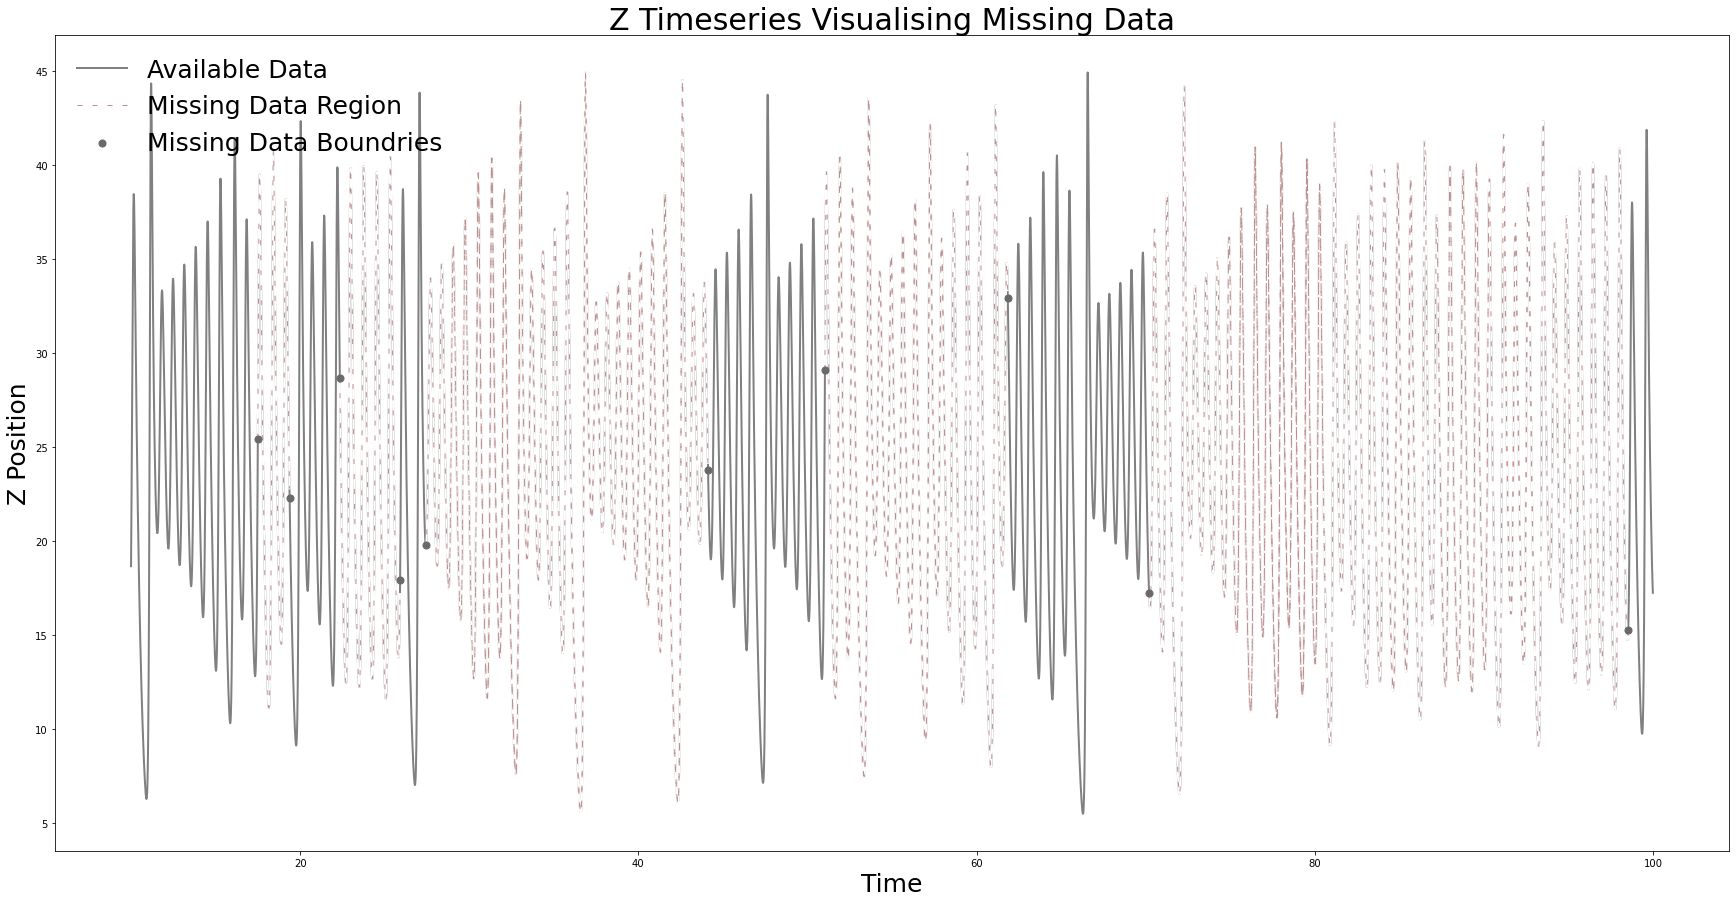

In [128]:
min_sec=1
max_sec=7
dt = t_eval[1]-t_eval[0]
z_missing, chunk_info = Missing_random_chunks(z, min_sec , max_sec ,dt)
merged_chunk_info = merge_chunks(chunk_info)

fig_missingdata_z = plt.figure(figsize = (30,15))
ax = fig_missingdata_z.add_subplot(1,1,1)
ax.plot(t, z, color='gray', lw=2, label='Available Data', zorder=1)

for i, (start, length) in enumerate(chunk_info):
    end = start + length
    if i==0:
        ax.plot(t[start:end], z[start:end], color='white', lw=2, zorder=2)
        line1, = ax.plot(t[start:end], z[start:end], color='rosybrown', lw=1, linestyle="--", zorder=3, label="Missing Data Region")
        line1.set_dashes([5, 10])
    else:
        ax.plot(t[start:end], z[start:end], color='white', lw=2, zorder=2)
        line2, = ax.plot(t[start:end], z[start:end], color='rosybrown', lw=1, linestyle="--", zorder=3)
        line2.set_dashes([5, 10])
        
for i, (start, length) in enumerate(merged_chunk_info):
    end = start + length
    time_bigchunk_scatter = np.array([t[start],t[end]])
    posi_bigchunk_scatter = np.array([z[start],z[end]])
    if i==0:
        ax.scatter(time_bigchunk_scatter,posi_bigchunk_scatter, color='dimgray', s=50, marker='o', label="Missing Data Boundries",zorder=4)
    else:
        ax.scatter(time_bigchunk_scatter,posi_bigchunk_scatter, color='dimgray', s=50, marker='o', zorder=4)

ax.set_xlabel("Time", fontsize = 25)
ax.set_ylabel("Z Position", fontsize = 25)
ax.set_title("Z Timeseries Visualising Missing Data", fontsize = 30)
ax.legend(fontsize=25,frameon=False)

In [61]:
filepath = "/Users/elliotlowe/Report/Chapter3_"
filename = "/ZMissing_Lorenz"

fig_missingdata_z.savefig(filepath+filename, dpi=300, bbox_inches='tight')

## 1.4 Test Taylorformer Model

In [129]:
def dataset_processor_OV(path_to_data):
    """this function loads a time series dataset from a CSV file, normalizes it feature-wise, sets the first 
    column to a linearly spaced range from -1 to 1 (used for time), and returns the first column as input x 
    and the last column as target y, both reshaped for model input."""

    pd_array = pd.read_csv(path_to_data)
    data = np.array(pd_array)
    data[:,0] = np.linspace(-1,1,data.shape[0])
    # we need to have it between -1 to 1 for each batch item not just overall
    data = data.astype("float32")
    data_scaled = (data - np.mean(data,axis=0))/np.std(data,axis=0)
    x, y = data_scaled[:,:1], data_scaled[:,-1:]

    return x[:,:,np.newaxis], y[:,:,np.newaxis]
    
def rescale_data(y_te,predictions,t,z,idx,select,n_C,n_T):
    """Rescales the data back to the original size of the lorenz"""
    
    index  = idx[select]
    maxval = index + n_C + n_T
    
    y_scaled = ((y_te[select]*(np.std(z,axis=0))) + np.mean(z,axis=0)) #[index:maxval]
    p_scaled = ((predictions[select]*(np.std(z,axis=0))) + np.mean(z,axis=0)) #[minval:maxval]
    time_arr = t[index:maxval]
    z_poi    = z[index:maxval]
    
    return y_scaled, p_scaled, time_arr, z_poi

In [131]:
# Calculates target and context point numbers for the missing chunks above

merged_chunk_info = np.array(merged_chunk_info)
CT_info = np.zeros(merged_chunk_info.shape)
original = 0

for i, (start, length) in enumerate(merged_chunk_info):
    #calculate target and context number
    n_T = length
    n_C = start - original
    CT_info[i] = np.array([n_C,n_T]) 
    
    #update original
    end = start + length
    original = end

In [132]:
chunk_size_arr = merged_chunk_info[:, -1]
start_idx_arr  = merged_chunk_info[:,  0]
num_chunks = merged_chunk_info.shape[0]
eval_batch_s = num_chunks

#CT_info has shape [n_C,n_T] 
n_T_arr = CT_info[:, -1]
n_C_arr = CT_info[:, 0]

x_full, y_full = dataset_processor_OV(path_to_data)

In [135]:
Full_CT = []
Predicted_Trejectories = []
time_arrays = []

for i in range(len(n_T_arr)):
    # 1. prep the data
    n_T = int(n_T_arr[i])
    n_C = int(n_C_arr[i])
    
    idx_batches = (start_idx_arr - n_C).astype(int)
    
    idx_list = list(range(x_full.shape[0] - (n_C + n_T)))
    t_te, y_te, idx_list = batcher_choice(x_full, y_full, idx_list, batch_s = eval_batch_s, window=n_C+n_T,idx=idx_batches)
    t_te = np.repeat(np.linspace(-1,1,(n_C+n_T))[np.newaxis,:,np.newaxis],axis=0,repeats=y_te.shape[0])
    μ, log_σ = model([t_te, y_te, n_C, n_T, False])
    predictions = μ.numpy()

    #s in 'rescale_data' depends where the gap in data starts
    s=i
    y_scaled, p_scaled, time_arr, z_poi = rescale_data(y_te,predictions,t,z,idx_batches,s,n_C,n_T)
    Predicted_Trejectories.append(p_scaled)
    time_arrays.append(time_arr)
    Full_CT.append(y_scaled)   

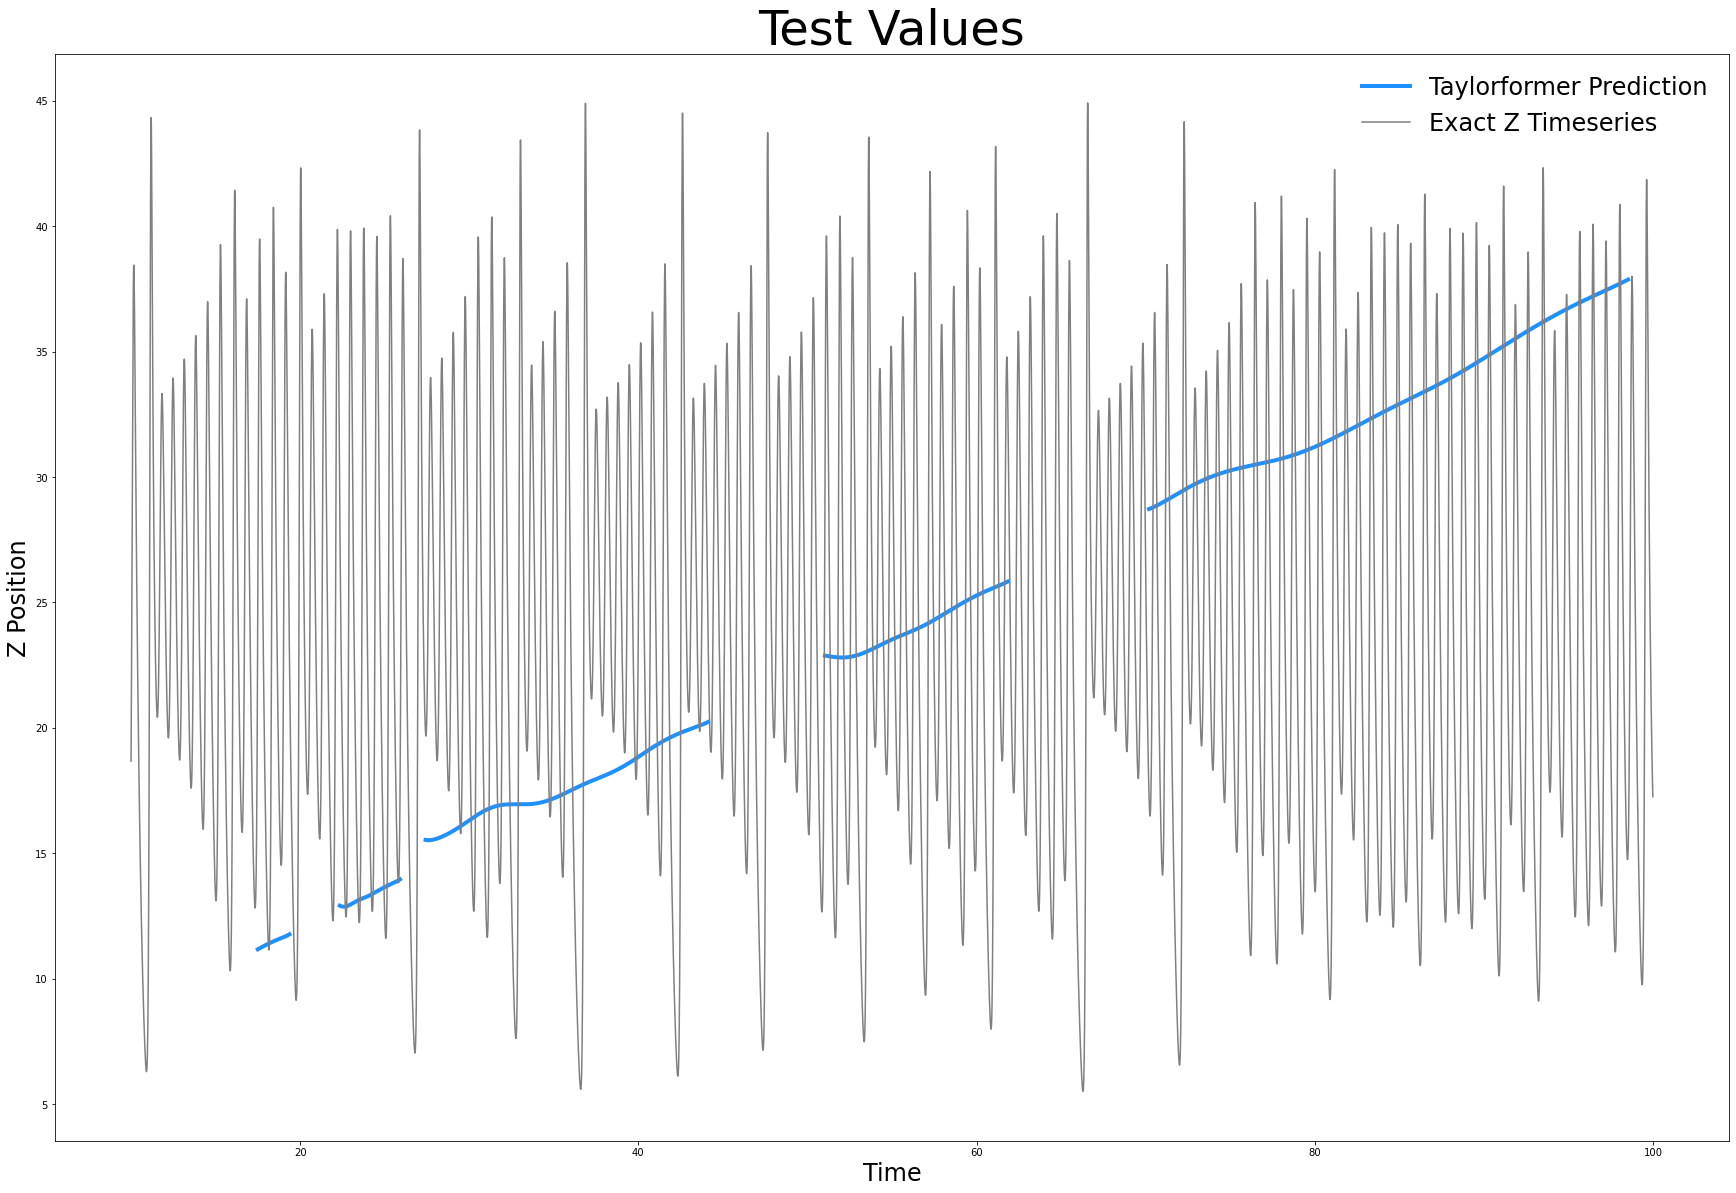

In [138]:
fig_taylorformer_pred = plt.figure(figsize=(30, 20))
ax = fig_taylorformer_pred.add_subplot(111)

#Loop through predictions
for i in range(len(n_T_arr)):
    gap_no = i
    time_arr   = np.array(time_arrays[gap_no])
    pred_traj  = np.array(Predicted_Trejectories[gap_no])
    time_array = t[start_idx_arr[gap_no]:start_idx_arr[gap_no]+chunk_size_arr[gap_no]]
    if i == 0:
        ax.plot(time_array, pred_traj, linewidth=4, color='dodgerblue', label="Taylorformer Prediction")
    else:
        ax.plot(time_array, pred_traj, linewidth=4, color='dodgerblue')
            
ax.plot(t,z, color='grey', label="Exact Z Timeseries")
ax.set_title('Test Values', fontsize=48)
ax.set_ylabel('Z Position', fontsize=24)
ax.set_xlabel('Time', fontsize=24)
ax.legend(fontsize=24,frameon=False)